# Deriving summary characteristics

## Fixing missing values

In [1]:
import pandas as pd

mapped_industry_data = pd.read_csv('./Data/full_data_mapped_industries_all_standards_all_levels_top_2.csv',sep='\t',low_memory=False)

In [2]:
mapped_industry_data.columns

Index(['application_number', 'top1_isic_rev4_1', 'top2_isic_rev4_1',
       'top1_isic_rev4_1_excl_service', 'top2_isic_rev4_1_excl_service',
       'top1_isic_rev4_2', 'top2_isic_rev4_2', 'top1_isic_rev4_2_excl_service',
       'top2_isic_rev4_2_excl_service', 'top1_isic_rev4_3', 'top2_isic_rev4_3',
       'top1_isic_rev4_3_excl_service', 'top2_isic_rev4_3_excl_service',
       'top1_isic_rev4_4', 'top2_isic_rev4_4', 'top1_isic_rev4_4_excl_service',
       'top2_isic_rev4_4_excl_service', 'top1_sitc_rev4_1', 'top2_sitc_rev4_1',
       'top1_sitc_rev4_2', 'top2_sitc_rev4_2', 'top1_sitc_rev4_3',
       'top2_sitc_rev4_3', 'top1_sitc_rev4_4', 'top2_sitc_rev4_4',
       'top1_sitc_rev4_45', 'top2_sitc_rev4_45', 'top1_naics07_1',
       'top2_naics07_1', 'top1_naics07_1_excl_service',
       'top2_naics07_1_excl_service', 'top1_naics07_2', 'top2_naics07_2',
       'top1_naics07_2_excl_service', 'top2_naics07_2_excl_service',
       'top1_naics07_3', 'top2_naics07_3', 'top1_naics07_3_excl_s

In [3]:
!pip install missingno
import missingno as msno

In [3]:
cols_with_missing = mapped_industry_data.columns[mapped_industry_data.isnull().any()]

In [4]:
msno.matrix(mapped_industry_data[cols_with_missing])

NameError: name 'msno' is not defined

In [5]:
import pandas as pd

# Assuming your dataframe is named mapped_industry_data

def calculate_missing_by_standard(df):
    standards = ['hs2007', 'naics07', 'isic_rev4', 'sitc_rev4']
    results = {}
    total_rows = len(df)

    for std in standards:
        results[std] = {'top1_%_missing': 0, 'top2_%_missing': 0}
        cols_top1 = [col for col in df.columns if col.startswith('top1_' + std) and 'excl_service' not in col]
        cols_top2 = [col for col in df.columns if col.startswith('top2_' + std) and 'excl_service' not in col]

        missing_top1 = df[cols_top1].isnull().sum().sum()
        missing_top2 = df[cols_top2].isnull().sum().sum()

        results[std]['top1_%_missing'] = (missing_top1 / (total_rows * len(cols_top1))) * 100 if cols_top1 else 0
        results[std]['top2_%_missing'] = (missing_top2 / (total_rows * len(cols_top2))) * 100 if cols_top2 else 0

    return pd.DataFrame(results)

def calculate_missing_by_standard_excl_service(df):
    standards = ['naics07', 'isic_rev4']  # only these have excl_service variants
    results_excl = {}
    total_rows = len(df)

    for std in standards:
        results_excl[std + '_excl_service'] = {'top1_%_missing': 0, 'top2_%_missing': 0}
        cols_top1_excl = [col for col in df.columns if col.startswith('top1_' + std) and 'excl_service' in col]
        cols_top2_excl = [col for col in df.columns if col.startswith('top2_' + std) and 'excl_service' in col]

        missing_top1 = df[cols_top1_excl].isnull().sum().sum()
        missing_top2 = df[cols_top2_excl].isnull().sum().sum()

        results_excl[std + '_excl_service']['top1_%_missing'] = (missing_top1 / (total_rows * len(cols_top1_excl))) * 100 if cols_top1_excl else 0
        results_excl[std + '_excl_service']['top2_%_missing'] = (missing_top2 / (total_rows * len(cols_top2_excl))) * 100 if cols_top2_excl else 0

    return pd.DataFrame(results_excl)

def fill_top2_with_top1(df):
    df_filled = df.copy()
    standards = ['hs2007', 'naics07', 'isic_rev4', 'sitc_rev4']
    aggregation_levels = ['1', '2', '3', '4', '45', '5', '6']  # all possible levels found in columns

    for std in standards:
        for level in aggregation_levels:
            top1_col = f'top1_{std}_{level}'
            top2_col = f'top2_{std}_{level}'
            
            if top1_col in df.columns and top2_col in df.columns:
                df_filled[top2_col] = df_filled[top2_col].fillna(df_filled[top1_col])
            
            top1_excl_col = f'top1_{std}_{level}_excl_service'
            top2_excl_col = f'top2_{std}_{level}_excl_service'
            
            if top1_excl_col in df.columns and top2_excl_col in df.columns:
                df_filled[top2_excl_col] = df_filled[top2_excl_col].fillna(df_filled[top1_excl_col])

    return df_filled

# Usage
missing_normal = calculate_missing_by_standard(mapped_industry_data)
missing_excl_service = calculate_missing_by_standard_excl_service(mapped_industry_data)

# Display
print("Missing Normal Standards (Percentage):")
print(missing_normal)
print("\nMissing Excl Service Standards (Percentage):")
print(missing_excl_service)

Missing Normal Standards (Percentage):
                  hs2007    naics07  isic_rev4  sitc_rev4
top1_%_missing  0.445424   0.445424   0.443976   0.445424
top2_%_missing  3.573552  12.253308   7.992287   4.167763

Missing Excl Service Standards (Percentage):
                naics07_excl_service  isic_rev4_excl_service
top1_%_missing              0.443976                0.443976
top2_%_missing             12.184074               18.059357


In [7]:
imputed_mapped_industry_data = fill_top2_with_top1(mapped_industry_data)

In [8]:
# Usage
missing_normal_filled = calculate_missing_by_standard(imputed_mapped_industry_data)
missing_excl_service_filled = calculate_missing_by_standard_excl_service(imputed_mapped_industry_data)

# Display
print("Missing Normal Filled Standards (Percentage):")
print(missing_normal_filled)
print("\nMissing Excl Filled Service Standards (Percentage):")
print(missing_excl_service_filled)

Missing Normal Filled Standards (Percentage):
                  hs2007   naics07  isic_rev4  sitc_rev4
top1_%_missing  0.445424  0.445424   0.443976   0.445424
top2_%_missing  0.445424  0.445424   0.443976   0.445424

Missing Excl Filled Service Standards (Percentage):
                naics07_excl_service  isic_rev4_excl_service
top1_%_missing              0.443976                0.443976
top2_%_missing              0.443976                0.443976


<Axes: >

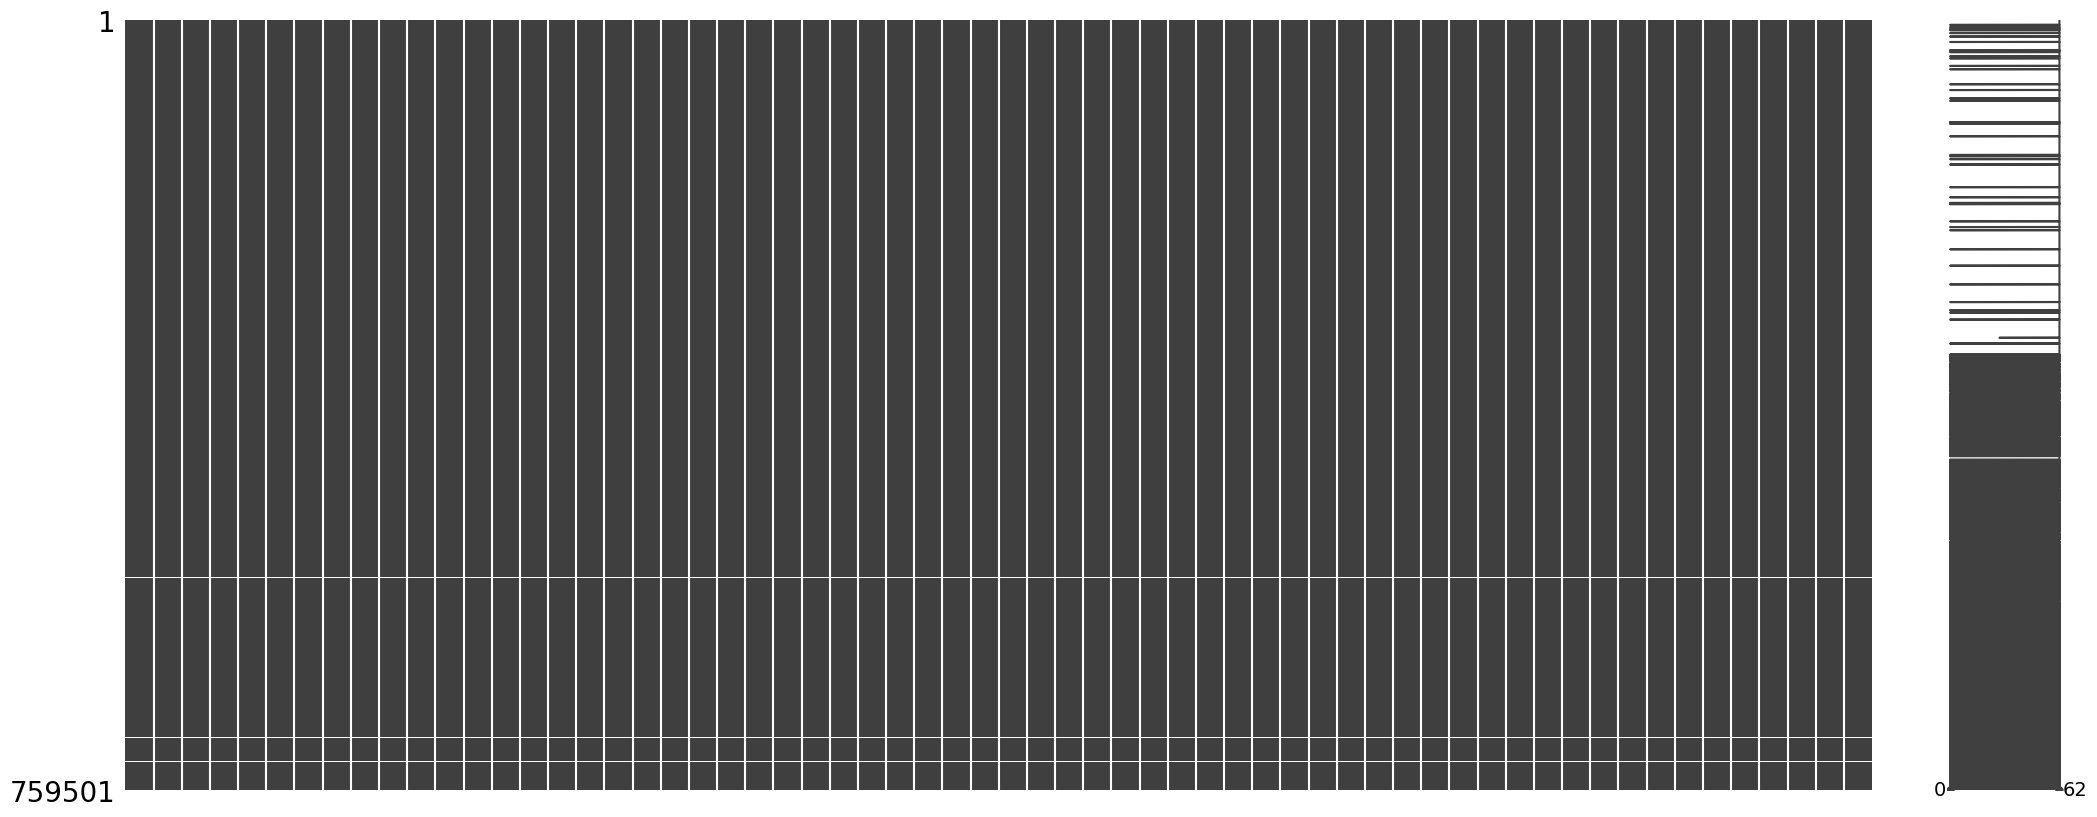

In [9]:


msno.matrix(imputed_mapped_industry_data[cols_with_missing])

In [10]:
# Make a copy to avoid modifying the original
imputed_mapped_industry_data_copy = imputed_mapped_industry_data.copy()

# Identify columns to cast (all except 'application_number')
cols_to_cast = imputed_mapped_industry_data_copy.columns.difference(['application_number'])

# Cast only the selected columns to string
imputed_mapped_industry_data_copy[cols_to_cast] = imputed_mapped_industry_data_copy[cols_to_cast].astype(str)

# After casting, replace 'nan' strings with 'Unknown'
final_mapped_industry_data = imputed_mapped_industry_data_copy.replace('nan', 'Unknown')

<Axes: >

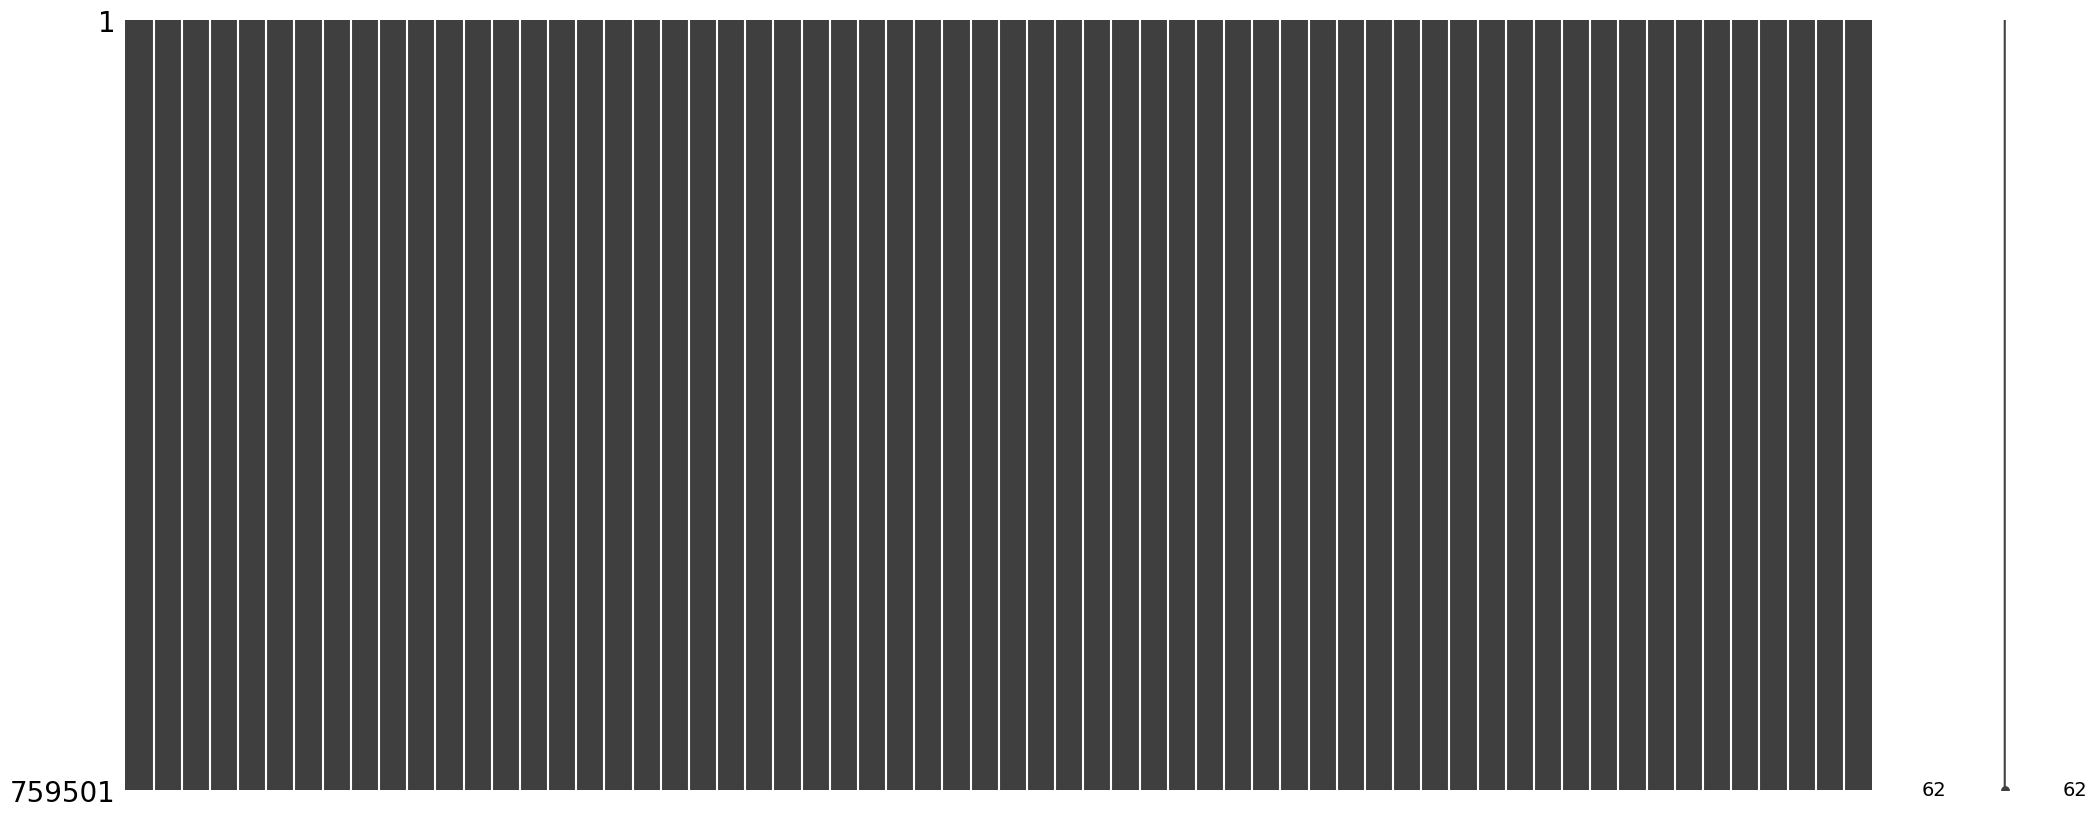

In [11]:
msno.matrix(final_mapped_industry_data[cols_with_missing])

In [12]:
final_mapped_industry_data.to_csv('./Data/full_data_mapped_industries_all_standards_all_levels_top_2_FILLED.csv',sep='\t',index=False)

## Summary mapping function testing 

In [13]:
final_mapped_industry_data

,application_number,top1_isic_rev4_1,top2_isic_rev4_1,top1_isic_rev4_1_excl_service,top2_isic_rev4_1_excl_service,top1_isic_rev4_2,top2_isic_rev4_2,top1_isic_rev4_2_excl_service,top2_isic_rev4_2_excl_service,top1_isic_rev4_3,...,top1_hs2007_2,top2_hs2007_2,top1_hs2007_3,top2_hs2007_3,top1_hs2007_4,top2_hs2007_4,top1_hs2007_5,top2_hs2007_5,top1_hs2007_6,top2_hs2007_6
0,9152603.8,C,D,C,D,27.0,26.0,27.0,26.0,272.0,...,85.0,87.0,850.0,853.0,8504.0,8506.0,85043.0,85068.0,850680.0,850440.0
1,9152612.9,C,Other,C,C,26.0,59.0,26.0,26.0,267.0,...,37.0,91.0,370.0,844.0,3701.0,3705.0,37025.0,37029.0,370510.0,901060.0
2,9152618.6,C,D,C,D,27.0,29.0,27.0,29.0,302.0,...,85.0,86.0,850.0,870.0,9031.0,8703.0,90318.0,87033.0,903180.0,870321.0
3,9152643.4,C,C,C,C,30.0,28.0,30.0,28.0,309.0,...,87.0,84.0,871.0,848.0,8714.0,8712.0,87149.0,87120.0,871200.0,871493.0
4,9152646.7,Other,C,C,C,59.0,61.0,26.0,26.0,592.0,...,85.0,91.0,851.0,910.0,8517.0,8517.0,85171.0,85176.0,851712.0,851761.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759496,24169125.2,C,C,C,C,28.0,25.0,28.0,25.0,281.0,...,82.0,87.0,820.0,870.0,8703.0,7206.0,82058.0,82052.0,820580.0,820520.0
759497,24169126.0,C,Other,C,E,86.0,32.0,32.0,25.0,862.0,...,90.0,82.0,902.0,901.0,9022.0,9018.0,90221.0,90183.0,901832.0,902290.0
759498,24169128.6,C,C,C,C,27.0,20.0,27.0,20.0,272.0,...,75.0,85.0,850.0,750.0,8506.0,8311.0,85065.0,85069.0,850650.0,850690.0
759499,24169129.4,Other,C,C,C,26.0,59.0,26.0,26.0,265.0,...,91.0,85.0,910.0,854.0,9105.0,9103.0,91059.0,91039.0,910599.0,910390.0


In [4]:
basic_patent_data.columns

Index(['application_number', 'filing_date', 'ipc_field', 'is_no_unity',
       'is_incomplete_search', 'is_no_search', 'applicant_names',
       'applicant_countries', 'inventor_names', 'inventor_countries',
       'representative_name', 'representative_country', 'patent_granted_date',
       'patent_granted', 'publication_types', 'publication_date',
       'publication_number', 'status', 'status_text', 'value_imputed',
       'application_status_target'],
      dtype='object')

### DATA LOADING 

In [1]:
import pandas as pd

industry_data = pd.read_csv('./Data/full_data_mapped_industries_all_standards_all_levels_top_2_FILLED.csv',sep='\t',low_memory=False)
basic_patent_data = pd.read_csv('./Data/basic_patent_data_PATSTAT_IMPUTED_TARGET.csv',sep='\t',low_memory=False)
basic_patent_data_columns_to_keep = ['application_number','applicant_names','inventor_names','representative_name',
                                     'patent_granted', 'publication_date','application_status_target','value_imputed']
basic_patent_data = basic_patent_data[basic_patent_data_columns_to_keep]

scraped_representative_data = pd.read_csv('./Data/representatives_scraped_and_cleaned',sep='\t')
with open('./Data/ip_company_names.txt', 'r') as file:
    ip_company_name_list = [line.strip() for line in file]

import json
with open('./Data/url_names_dictionary', 'r') as file:
    url_names_dict = json.load(file)


scraped_representative_data.drop(columns = ['company_identifier','Unnamed: 0','region'],inplace=True)

ip_company_urls = set()

for name in ip_company_name_list:
    for url in url_names_dict.keys():
        if name in url_names_dict[url]:
            ip_company_urls.add(url)

name_url_dict = {}

for key in url_names_dict.keys():
    if key in ['https://ficpi.org','https://www.epo.org']:
        continue
    curr_list = url_names_dict[key]
    for item in curr_list:
        name_url_dict[item]=key

for item in ['https://ficpi.org','https://www.epo.org']: # we remove these cause they serve as indicies for IP attorneys
    ip_company_urls.remove(item)

scraped_representative_data_only_ip_companies = scraped_representative_data[
    scraped_representative_data['company_url'].isin(ip_company_urls)
]

import ast

basic_patent_data['inventor_names'] = basic_patent_data['inventor_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

basic_patent_data['applicant_names'] = basic_patent_data['applicant_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)



basic_patent_data['publication_date_date_time'] = pd.to_datetime(basic_patent_data['publication_date'],errors='coerce')
basic_patent_data['publication_year'] = basic_patent_data['publication_date_date_time'].map(lambda x: x.year)

In [1]:
import pandas as pd

# Copy the original
basic_patent_data_added_context_for_attorneys = basic_patent_data.copy()

# 1) Scraped attorneys (people) → URL
scraped_map = (
    scraped_representative_data_only_ip_companies
      .rename(columns={'attorney_name': 'representative_name'})
      [['representative_name', 'company_url']]
)

# 2) Company names → URL (from name_url_dict)
dict_map = (
    pd.DataFrame.from_dict(
        name_url_dict,                # keys are company names
        orient='index',
        columns=['company_url']
    )
    .rename_axis('representative_name')
    .reset_index()
)

# 3) Combine the two lookups
rep_map = pd.concat([scraped_map, dict_map], ignore_index=True)

# 4) Merge into the patents table
basic_patent_data_added_context_for_attorneys = (
    basic_patent_data_added_context_for_attorneys
      .merge(rep_map, how='left', on='representative_name')
)

# 5) Flags

# 5a) is_inhouse_flag: True if no external URL found
basic_patent_data_added_context_for_attorneys['is_inhouse_flag'] = (
    basic_patent_data_added_context_for_attorneys['company_url'].isna()
)

# 5b) is_company: True if rep name matches one of the company names
basic_patent_data_added_context_for_attorneys['is_company'] = (
    basic_patent_data_added_context_for_attorneys['representative_name']
      .isin(name_url_dict.keys())
)

# 6) (Optional) replace NaN with None for readability
basic_patent_data_added_context_for_attorneys['company_url'] = (
    basic_patent_data_added_context_for_attorneys['company_url']
      .where(~basic_patent_data_added_context_for_attorneys['is_inhouse_flag'], None)
)


NameError: name 'basic_patent_data' is not defined

In [6]:
# basic_patent_data_added_context_for_attorneys.to_csv('./Data/basic_patent_data_added_context_for_attorneys.csv',sep='\t')

In [ ]:
import ast

# Function to safely convert strings to lists and return their length
def safe_to_list_and_len(val):
    if isinstance(val, list):
        return len(val)
    elif isinstance(val, str):
        try:
            # Try to parse string representation of a list (e.g. "['a', 'b']")
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return len(parsed)
        except (ValueError, SyntaxError):
            pass
    return 0  # For NaN, None, or failed conversions

# List of columns to process
cols = ['applicant_names', 'inventor_names']

# Apply the function to each column and store length in a new column
for col in cols:
    new_col = col + '_array_length'
    basic_patent_data[new_col] = basic_patent_data[col].apply(safe_to_list_and_len)

# Print value counts
for col in cols:
    length_col = col + '_array_length'
    print(f"\nValue counts for {length_col}:")
    print(basic_patent_data[length_col].value_counts().sort_index())


In [5]:
basic_patent_data_added_context_for_attorneys = pd.read_csv('./Data/basic_patent_data_added_context_for_attorneys.csv',sep='\t',low_memory=False)

basic_patent_data_added_context_for_attorneys.drop(columns= ['Unnamed: 0'],inplace=True)

basic_patent_data['publication_date_date_time'] = pd.to_datetime(basic_patent_data['publication_date'],errors='coerce')

not_num_target_cols = set(basic_patent_data.columns) - set (['application_number', 'application_status_target','publication_date_date_time'])

app_num_target_df = basic_patent_data.drop(columns = not_num_target_cols)

industry_data_with_target = pd.merge(app_num_target_df, industry_data, on='application_number', how='inner')

### Function Mapping For Basic Summary Characteristics (NO CLASSIFICATION DATA ADDED)

In [6]:
basic_patent_data_added_context_for_attorneys.columns

Index(['application_number', 'applicant_names', 'inventor_names',
       'representative_name', 'patent_granted', 'publication_date',
       'application_status_target', 'value_imputed',
       'publication_date_date_time', 'publication_year', 'company_url',
       'is_inhouse_flag', 'is_company'],
      dtype='object')

In [6]:
# Re-import after reset
import pandas as pd
import numpy as np
from collections import defaultdict
from pandas.api.types import is_datetime64_any_dtype

# Helpers
def _is_nan_like(obj):
    return obj is None or (isinstance(obj, float) and pd.isna(obj))

def _build_list_entity_dict(list_col, status_col):
    acc = defaultdict(lambda: {'total': 0, 'status1': 0, 'status_minus1': 0})
    for names, status in zip(list_col, status_col):
        if _is_nan_like(names):
            continue
        if not isinstance(names, (list, tuple, set)):
            names = [names]
        for n in names:
            acc[n]['total'] += 1
            if status == 1:
                acc[n]['status1'] += 1
            elif status == -1:
                acc[n]['status_minus1'] += 1
    return acc

def _build_single_entity_dict(series, status_col):
    acc = defaultdict(lambda: {'total': 0, 'status1': 0, 'status_minus1': 0})
    for ent, status in zip(series, status_col):
        if _is_nan_like(ent):
            continue
        acc[ent]['total'] += 1
        if status == 1:
            acc[ent]['status1'] += 1
        elif status == -1:
            acc[ent]['status_minus1'] += 1
    return acc

def _min_max_mean(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return np.nan, np.nan, np.nan
    return arr.min(), arr.max(), arr.mean()

# Main: updated generate_summary_features with 0excl ratios
def generate_summary_features(
    df: pd.DataFrame,
    cutoff_year: int,
    date_col: str = "publication_date_date_time",
    id_col: str = "application_number",
    keep_original_cols: bool = False
) -> pd.DataFrame:

    if not is_datetime64_any_dtype(df[date_col]):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    past_df = df[df[date_col].dt.year <= cutoff_year]

    applicant_dict = _build_list_entity_dict(
        past_df["applicant_names"], past_df["application_status_target"]
    )
    inventor_dict = _build_list_entity_dict(
        past_df["inventor_names"], past_df["application_status_target"]
    )
    representative_dict = _build_single_entity_dict(
        past_df["representative_name"], past_df["application_status_target"]
    )
    company_dict = _build_single_entity_dict(
        past_df.loc[past_df["is_company"], "company_url"],
        past_df.loc[past_df["is_company"], "application_status_target"]
    )

    out_df = df.copy() if keep_original_cols else df[[id_col]].copy()

    def _row_stats(name_list, ref_dict):
        if _is_nan_like(name_list) or not name_list:
            return [np.nan] * 9
        if not isinstance(name_list, (list, tuple, set)):
            name_list = [name_list]
        totals, ratio1s, ratio1_0excls = [], [], []
        for n in name_list:
            info = ref_dict.get(n, {"total": 0, "status1": 0, "status_minus1": 0})
            total = info["total"]
            ratio1 = info["status1"] / total if total else 0
            denom_0excl = info["status1"] + info["status_minus1"]
            ratio1_0excl = info["status1"] / denom_0excl if denom_0excl > 0 else 0
            totals.append(total)
            ratio1s.append(ratio1)
            ratio1_0excls.append(ratio1_0excl)
        return list(_min_max_mean(totals) + _min_max_mean(ratio1s) + _min_max_mean(ratio1_0excls))

    def _rep_stats(rep_name):
        info = representative_dict.get(rep_name)
        if info is None:
            return pd.Series([0, 0, 0])
        total = info["total"]
        ratio1 = info["status1"] / total if total else 0
        denom_0excl = info["status1"] + info["status_minus1"]
        ratio1_0excl = info["status1"] / denom_0excl if denom_0excl > 0 else 0
        return pd.Series([total, ratio1, ratio1_0excl])

    def _company_stats(row):
        if not row["is_company"] or _is_nan_like(row["company_url"]):
            return pd.Series([np.nan, np.nan, np.nan])
        info = company_dict.get(row["company_url"])
        if info is None:
            return pd.Series([0, 0, 0])
        total = info["total"]
        ratio1 = info["status1"] / total if total else 0
        denom_0excl = info["status1"] + info["status_minus1"]
        ratio1_0excl = info["status1"] / denom_0excl if denom_0excl > 0 else 0
        return pd.Series([total, ratio1, ratio1_0excl])

    out_df[
        [
            "applicant_num_entries_min",
            "applicant_num_entries_max",
            "applicant_num_entries_mean",
            "applicant_ratio1_min",
            "applicant_ratio1_max",
            "applicant_ratio1_mean",
            "applicant_0excl_ratio1_min",
            "applicant_0excl_ratio1_max",
            "applicant_0excl_ratio1_mean",
        ]
    ] = df["applicant_names"].apply(_row_stats, args=(applicant_dict,)).apply(pd.Series)

    out_df[
        [
            "inventor_num_entries_min",
            "inventor_num_entries_max",
            "inventor_num_entries_mean",
            "inventor_ratio1_min",
            "inventor_ratio1_max",
            "inventor_ratio1_mean",
            "inventor_0excl_ratio1_min",
            "inventor_0excl_ratio1_max",
            "inventor_0excl_ratio1_mean",
        ]
    ] = df["inventor_names"].apply(_row_stats, args=(inventor_dict,)).apply(pd.Series)

    out_df[["representative_num_entries", "representative_ratio1", "representative_0excl_ratio1"]] = (
        df["representative_name"].apply(_rep_stats)
    )

    out_df[["ip_company_level_num_entries", "ip_company_ratio_1", "ip_company_0excl_ratio_1"]] = (
        df.apply(_company_stats, axis=1)
    )

    return out_df


In [7]:
import os
import pandas as pd

# ──────────────────────────────────────────────────────────────────────────
#  ASSUMPTION:  generate_summary_features(df, year) is already in memory
#               exactly as revised (with robust NaN handling).
# ──────────────────────────────────────────────────────────────────────────

CUT_OFF_YEARS = [2015, 2016, 2017, 2018, 2019]

OUT_BASE = "./Data/summary_statistics"
FOLDERS = {
    "applicant": f"{OUT_BASE}/applicant_summary_statistics",
    "inventor":  f"{OUT_BASE}/inventor_summary_statistics",
    "attorney":  f"{OUT_BASE}/attorney_summary_statistics",
}

# make sure sub-dirs exist
for p in FOLDERS.values():
    os.makedirs(p, exist_ok=True)

def save_yearly_row_features(df: pd.DataFrame,
                             years=CUT_OFF_YEARS) -> None:
    """
    For each cut-off year create three files:
        applicant, inventor and attorney summary features
    (only 'application_number' + the feature columns), saved as TSV.
    """
    for yr in years:
        print(f"▶ building row-level features up to {yr} …")
        enriched = generate_summary_features(df, yr)

        # column groupings
        applicant_cols = (
            ["application_number"] +
            [c for c in enriched.columns if c.startswith("applicant_")]
        )
        inventor_cols = (
            ["application_number"] +
            [c for c in enriched.columns if c.startswith("inventor_")]
        )
        attorney_cols = (
            ["application_number",
             "representative_num_entries", "representative_ratio1",
             "ip_company_level_num_entries", "ip_company_ratio_1"]
        )

        # write to disk
        enriched[applicant_cols].to_csv(
            f"{FOLDERS['applicant']}/basic_applicant_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        enriched[inventor_cols].to_csv(
            f"{FOLDERS['inventor']}/basic_inventor_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        enriched[attorney_cols].to_csv(
            f"{FOLDERS['attorney']}/basic_attorney_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        print(f"  ✓ saved files for {yr}")


In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Union
from pandas.api.types import is_datetime64_any_dtype


# ------------------------------------------------------------
# helpers
# ------------------------------------------------------------

def _is_nan_like(obj: Union[float, None]) -> bool:
    """Return True when obj is None **or** a scalar NaN (float)."""
    return obj is None or (isinstance(obj, float) and pd.isna(obj))


def _build_list_entity_dict(list_col, status_col):
    """
    Build {entity: {'total': n_total, 'status1': n_granted}} for list‑type
    columns (applicants, inventors).
    Safely handles rows that are NaN, None, or an arbitrary scalar.
    """
    acc = defaultdict(lambda: {'total': 0, 'status1': 0})
    for names, status in zip(list_col, status_col):
        # skip missing
        if _is_nan_like(names):
            continue
        # ensure iterable
        if not isinstance(names, (list, tuple, set)):
            names = [names]
        for n in names:
            acc[n]['total'] += 1
            if status == 1:
                acc[n]['status1'] += 1
    return acc


def _build_single_entity_dict(series, status_col):
    """
    Build {entity: {'total': n_total, 'status1': n_granted}}
    for scalar columns (representative or company_url).
    """
    acc = defaultdict(lambda: {'total': 0, 'status1': 0})
    for ent, status in zip(series, status_col):
        if _is_nan_like(ent):
            continue
        acc[ent]['total'] += 1
        if status == 1:
            acc[ent]['status1'] += 1
    return acc


def _min_max_mean(arr):
    """Return (min, max, mean) for a numeric iterable; NaN if empty."""
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return np.nan, np.nan, np.nan
    return arr.min(), arr.max(), arr.mean()


# ------------------------------------------------------------
# main function
# ------------------------------------------------------------

import pandas as pd
import numpy as np
from pandas.api.types import is_datetime64_any_dtype

# -------------------------------------------------------------------
# generate_summary_features   ❶ NEW VERSION
# -------------------------------------------------------------------
def generate_summary_features(
    df: pd.DataFrame,
    cutoff_year: int,
    *,
    date_col: str = "publication_date_date_time",
    id_col: str   = "application_number",
    keep_original_cols: bool = False  # True ⇒ return full df + features
) -> pd.DataFrame:
    """
    Build summary statistics using data up to **cutoff_year** (inclusive)
    and attach those frozen stats to **every** row in *df*.

    Parameters
    ----------
    df  : DataFrame  – source data.
    cutoff_year : int
    date_col : str    – column holding publication dates.
    id_col   : str    – column that uniquely identifies a patent row.
    keep_original_cols : bool
        • False (default) → output = id_col + new feature columns only.  
        • True            → output = full original dataframe + new features.
    """

    # 0 ▸ ensure we can use .dt.year safely -----------------------
    if not is_datetime64_any_dtype(df[date_col]):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # 1 ▸ rows *up to* the cut-off build the lookup dictionaries --
    past_df = df.loc[df[date_col].dt.year <= cutoff_year]

    applicant_dict      = _build_list_entity_dict(
        past_df["applicant_names"], past_df["application_status_target"]
    )
    inventor_dict       = _build_list_entity_dict(
        past_df["inventor_names"],  past_df["application_status_target"]
    )
    representative_dict = _build_single_entity_dict(
        past_df["representative_name"], past_df["application_status_target"]
    )
    company_dict        = _build_single_entity_dict(
        past_df.loc[past_df["is_company"], "company_url"],
        past_df.loc[past_df["is_company"], "application_status_target"],
    )

    # 2 ▸ choose what to start from ------------------------------
    out_df = df.copy() if keep_original_cols else df[[id_col]].copy()

    # 3 ▸ helper lambdas that reference the frozen dictionaries ---
    def _row_stats(name_list, ref_dict):
        if _is_nan_like(name_list) or not name_list:
            return [np.nan] * 6
        if not isinstance(name_list, (list, tuple, set)):
            name_list = [name_list]

        totals, ratios = [], []
        for n in name_list:
            info   = ref_dict.get(n, {"total": 0, "status1": 0})
            total  = info["total"]
            ratio  = info["status1"] / total if total else 0
            totals.append(total)
            ratios.append(ratio)

        return list(_min_max_mean(totals) + _min_max_mean(ratios))

    def _rep_stats(rep_name):
        info  = representative_dict.get(rep_name)
        if info is None:
            return pd.Series([0, 0])
        total = info["total"]
        ratio = info["status1"] / total if total else 0
        return pd.Series([total, ratio])

    def _company_stats(row):
        if not row["is_company"] or _is_nan_like(row["company_url"]):
            return pd.Series([np.nan, np.nan])
        info  = company_dict.get(row["company_url"])
        if info is None:
            return pd.Series([0, 0])
        total = info["total"]
        ratio = info["status1"] / total if total else 0
        return pd.Series([total, ratio])

    # 4 ▸ compute & attach all feature blocks --------------------
    out_df[[
        "applicant_num_entries_min",
        "applicant_num_entries_max",
        "applicant_num_entries_mean",
        "applicant_ratio1_min",
        "applicant_ratio1_max",
        "applicant_ratio1_mean",
    ]] = df["applicant_names"].apply(_row_stats, args=(applicant_dict,)).apply(pd.Series)

    out_df[[
        "inventor_num_entries_min",
        "inventor_num_entries_max",
        "inventor_num_entries_mean",
        "inventor_ratio1_min",
        "inventor_ratio1_max",
        "inventor_ratio1_mean",
    ]] = df["inventor_names"].apply(_row_stats, args=(inventor_dict,)).apply(pd.Series)

    out_df[["representative_num_entries", "representative_ratio1"]] = (
        df["representative_name"].apply(_rep_stats)
    )

    out_df[["ip_company_level_num_entries", "ip_company_ratio_1"]] = (
        df.apply(_company_stats, axis=1)
    )

    return out_df


import os
import pandas as pd

# ──────────────────────────────────────────────────────────────────────────
#  ASSUMPTION:  generate_summary_features(df, year) is already in memory
#               exactly as revised (with robust NaN handling).
# ──────────────────────────────────────────────────────────────────────────

CUT_OFF_YEARS = [2015, 2016, 2017, 2018, 2019]

OUT_BASE = "./Data/summary_statistics"
FOLDERS = {
    "applicant": f"{OUT_BASE}/applicant_summary_statistics",
    "inventor":  f"{OUT_BASE}/inventor_summary_statistics",
    "attorney":  f"{OUT_BASE}/attorney_summary_statistics",
}

# make sure sub-dirs exist
for p in FOLDERS.values():
    os.makedirs(p, exist_ok=True)

def save_yearly_row_features(df: pd.DataFrame,
                             years=CUT_OFF_YEARS) -> None:
    """
    For each cut-off year create three files:
        applicant, inventor and attorney summary features
    (only 'application_number' + the feature columns), saved as TSV.
    """
    for yr in years:
        print(f"▶ building row-level features up to {yr} …")
        enriched = generate_summary_features(df, yr)

        # column groupings
        applicant_cols = (
            ["application_number"] +
            [c for c in enriched.columns if c.startswith("applicant_")]
        )
        inventor_cols = (
            ["application_number"] +
            [c for c in enriched.columns if c.startswith("inventor_")]
        )
        attorney_cols = (
            ["application_number",
             "representative_num_entries", "representative_ratio1",
             "ip_company_level_num_entries", "ip_company_ratio_1"]
        )

        # write to disk
        enriched[applicant_cols].to_csv(
            f"{FOLDERS['applicant']}/basic_applicant_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        enriched[inventor_cols].to_csv(
            f"{FOLDERS['inventor']}/basic_inventor_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        enriched[attorney_cols].to_csv(
            f"{FOLDERS['attorney']}/basic_attorney_summary_characteristics_cutoff_{yr}.csv",
            sep="\t", index=False,
        )
        print(f"  ✓ saved files for {yr}")

# -----------------------------------------------------------------------
# USAGE:
# save_yearly_row_features(basic_patent_data_added_context_for_attorneys)




In [8]:
save_yearly_row_features(basic_patent_data_added_context_for_attorneys)

▶ building row-level features up to 2015 …
  ✓ saved files for 2015
▶ building row-level features up to 2016 …
  ✓ saved files for 2016
▶ building row-level features up to 2017 …
  ✓ saved files for 2017
▶ building row-level features up to 2018 …
  ✓ saved files for 2018
▶ building row-level features up to 2019 …
  ✓ saved files for 2019


### Function Mapping For Basic Summary Characteristsics based only on Classification data (NO PARTIES DATA ADDED)

This section features the functions used to map the summary characteristics for each industry at each level of aggregation (across all of the standards used).
The summary charateristics are based only on the industry classification data and the target collumn, they do not feature data about the parties of the patent application (tha parties are Applicant, Inventor and Representative). 


IMPORTANT NOTE: From this point on the code and everythign else is duplicated in another file. This is because the virtual machine this was running had limited space and the derved characteristics filled up all of it. 

In [2]:
basic_patent_data['publication_date_date_time'] = pd.to_datetime(basic_patent_data['publication_date'],errors='coerce')

not_num_target_cols = set(basic_patent_data.columns) - set (['application_number', 'application_status_target','publication_date_date_time'])

app_num_target_df = basic_patent_data.drop(columns = not_num_target_cols)

industry_data_with_target = pd.merge(app_num_target_df, industry_data, on='application_number', how='inner')

In [4]:
#industry_data_with_target.to_csv('./industry_data_with_target.csv',sep = '\t',index=False)

In [3]:
industry_data_with_target.columns

Index(['application_number', 'application_status_target',
       'publication_date_date_time', 'top1_isic_rev4_1', 'top2_isic_rev4_1',
       'top1_isic_rev4_1_excl_service', 'top2_isic_rev4_1_excl_service',
       'top1_isic_rev4_2', 'top2_isic_rev4_2', 'top1_isic_rev4_2_excl_service',
       'top2_isic_rev4_2_excl_service', 'top1_isic_rev4_3', 'top2_isic_rev4_3',
       'top1_isic_rev4_3_excl_service', 'top2_isic_rev4_3_excl_service',
       'top1_isic_rev4_4', 'top2_isic_rev4_4', 'top1_isic_rev4_4_excl_service',
       'top2_isic_rev4_4_excl_service', 'top1_sitc_rev4_1', 'top2_sitc_rev4_1',
       'top1_sitc_rev4_2', 'top2_sitc_rev4_2', 'top1_sitc_rev4_3',
       'top2_sitc_rev4_3', 'top1_sitc_rev4_4', 'top2_sitc_rev4_4',
       'top1_sitc_rev4_45', 'top2_sitc_rev4_45', 'top1_naics07_1',
       'top2_naics07_1', 'top1_naics07_1_excl_service',
       'top2_naics07_1_excl_service', 'top1_naics07_2', 'top2_naics07_2',
       'top1_naics07_2_excl_service', 'top2_naics07_2_excl_service',

In [4]:
to_drop = ['top1_naics07_1','top1_naics07_2','top1_naics07_3','top1_naics07_4','top1_naics07_5','top1_naics07_6',
          'top2_naics07_1','top2_naics07_2','top2_naics07_3','top2_naics07_4','top2_naics07_5','top2_naics07_6',
          'top1_isic_rev4_1','top1_isic_rev4_2','top1_isic_rev4_3','top1_isic_rev4_4',
          'top2_isic_rev4_1','top2_isic_rev4_2','top2_isic_rev4_3','top2_isic_rev4_4']

In [5]:
industry_data_with_target.drop(columns = to_drop,inplace=True)

In [6]:
industry_data_with_target.columns

Index(['application_number', 'application_status_target',
       'publication_date_date_time', 'top1_isic_rev4_1_excl_service',
       'top2_isic_rev4_1_excl_service', 'top1_isic_rev4_2_excl_service',
       'top2_isic_rev4_2_excl_service', 'top1_isic_rev4_3_excl_service',
       'top2_isic_rev4_3_excl_service', 'top1_isic_rev4_4_excl_service',
       'top2_isic_rev4_4_excl_service', 'top1_sitc_rev4_1', 'top2_sitc_rev4_1',
       'top1_sitc_rev4_2', 'top2_sitc_rev4_2', 'top1_sitc_rev4_3',
       'top2_sitc_rev4_3', 'top1_sitc_rev4_4', 'top2_sitc_rev4_4',
       'top1_sitc_rev4_45', 'top2_sitc_rev4_45', 'top1_naics07_1_excl_service',
       'top2_naics07_1_excl_service', 'top1_naics07_2_excl_service',
       'top2_naics07_2_excl_service', 'top1_naics07_3_excl_service',
       'top2_naics07_3_excl_service', 'top1_naics07_4_excl_service',
       'top2_naics07_4_excl_service', 'top1_naics07_5_excl_service',
       'top2_naics07_5_excl_service', 'top1_naics07_6_excl_service',
       'top2_n

In [7]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

def _target_count_dict(df: pd.DataFrame, col: str) -> Dict[str, Dict[str, int]]:
    """
    Returns {industry_code: {'count_-1': n, 'count_0': n, 'count_1': n}}
    for a single *_top… column.
    """
    # tabulate – missing classes become zero
    counts = (
        df.groupby(col)["application_status_target"]
          .value_counts()
          .unstack(fill_value=0)
          .reindex(columns=[-1, 0, 1], fill_value=0)   # guaranteed order
    )
    return {
        code: {
            "count_-1": int(r[-1]),
            "count_0":  int(r[0]),
            "count_1":  int(r[1]),
        }
        for code, r in counts.iterrows()
    }


def _ratio_features_from_dict(df: pd.DataFrame,
                              col: str,
                              count_dict: Dict[str, Dict[str, int]]
                             ) -> pd.DataFrame:
    """
    Maps each row’s code in *col* to the required ratio features and
    returns a small DataFrame with identical index.
    """
    # Build small lookup frames for fast vectorised mapping ----------
    tmp = pd.DataFrame.from_dict(count_dict, orient="index")
    tmp["total"]        = tmp[["count_-1", "count_0", "count_1"]].sum(axis=1)
    tmp["total_0excl"]  = tmp[["count_-1", "count_1"]].sum(axis=1).replace(0, np.nan)

    # All-class ratios
    for c in (-1, 0, 1):
        tmp[f"ratio_{c}"] = tmp[f"count_{c}"] / tmp["total"]

    # 0-excluded ratios  (only –1 and 1 matter)
    for c in (-1, 1):
        tmp[f"0excl_ratio_{c}"] = tmp[f"count_{c}"] / tmp["total_0excl"]

    # Map to original rows -------------------------------------------
    return (
        df[[col]]                          # keep code only
          .join(tmp, on=col)               # broadcast ratios
          .filter(regex="^ratio_|^0excl_") # keep ratio columns
          .rename(columns=lambda s: f"{col}_{s}")  # final names
    )

def build_industry_summary_features(
        df: pd.DataFrame,
        top_prefix: str = "top"
    ) -> Tuple[pd.DataFrame, Dict[str, Dict[str, Dict[str, int]]]]:
    """
    • Scans all columns whose name starts with *top_prefix*.
    • Returns:
        (A) summary-feature DataFrame (application_number + new ratios)
        (B) nested dict {column_name: {industry_code: {...counts...}}}
    """
    top_cols = [c for c in df.columns if c.startswith(top_prefix)]
    all_dicts = {}

    # Start with id column
    features = pd.DataFrame({"application_number": df["application_number"]})

    for col in top_cols:
        count_dict = _target_count_dict(df, col)
        all_dicts[col] = count_dict

        # build & attach ratio columns
        features = pd.concat(
            [features, _ratio_features_from_dict(df, col, count_dict)],
            axis=1
        )

    return features, all_dicts


def make_and_save_industry_summaries(
        df: pd.DataFrame,
        cutoff_years: List[int] = [2015, 2016, 2017, 2018, 2019],
        out_dir: str = "./Data/summary_statistics/industry_only_summary_statistics",
        verbose: bool = True,
        date_col: str = "publication_date_date_time",
        top_prefix: str = "top",
    ) -> None:
    """
    For each year in *cutoff_years*:
      • use rows with publication ≤ year to build target-count dictionaries
      • attach the resulting ratio features to **all** rows in *df*
      • save a TSV (application_number + ratio columns) to *out_dir*
    """
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    # Make sure the date column is a proper datetime ----------------------
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Identify the “top…” columns just once
    top_cols = [c for c in df.columns if c.startswith(top_prefix)]

    for yr in cutoff_years:
        # ── 1 ▸ rows allowed to contribute to the dictionaries
        past_df = df[df[date_col].dt.year <= yr]

        # ── 2 ▸ build ALL dictionaries on that frozen slice
        dict_by_col = {
            col: _target_count_dict(past_df, col)
            for col in top_cols
        }

        # ── 3 ▸ map those dictionaries to EVERY row in the original df
        feat_df = pd.DataFrame({
            "application_number": df["application_number"]
        })
        for col in top_cols:
            feat_df = pd.concat(
                [feat_df,
                 _ratio_features_from_dict(df, col, dict_by_col[col])],
                axis=1
            )

        # ── 4 ▸ write to disk
        fname = out / f"industry_only_summary_characteristics_cutoff_{yr}.csv"
        feat_df.to_csv(fname, sep="\t", index=False)

        if verbose:
            print(f"[{yr}] → saved {fname}  ({len(feat_df):,} rows)")


In [8]:
make_and_save_industry_summaries(industry_data_with_target)

[2015] → saved Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2015.csv  (759,501 rows)
[2016] → saved Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2016.csv  (759,501 rows)
[2017] → saved Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2017.csv  (759,501 rows)
[2018] → saved Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2018.csv  (759,501 rows)
[2019] → saved Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2019.csv  (759,501 rows)


In [15]:
test = pd.read_csv('./Data/summary_statistics/industry_only_summary_statistics/industry_only_summary_characteristics_cutoff_2019.csv',sep='\t')

In [16]:
test

,application_number,top1_isic_rev4_1_ratio_-1,top1_isic_rev4_1_ratio_0,top1_isic_rev4_1_ratio_1,top1_isic_rev4_1_0excl_ratio_-1,top1_isic_rev4_1_0excl_ratio_1,top2_isic_rev4_1_ratio_-1,top2_isic_rev4_1_ratio_0,top2_isic_rev4_1_ratio_1,top2_isic_rev4_1_0excl_ratio_-1,...,top1_hs2007_6_ratio_-1,top1_hs2007_6_ratio_0,top1_hs2007_6_ratio_1,top1_hs2007_6_0excl_ratio_-1,top1_hs2007_6_0excl_ratio_1,top2_hs2007_6_ratio_-1,top2_hs2007_6_ratio_0,top2_hs2007_6_ratio_1,top2_hs2007_6_0excl_ratio_-1,top2_hs2007_6_0excl_ratio_1
0,1000269.9,0.354552,0.089038,0.556410,0.389207,0.610793,0.291562,0.070058,0.638379,0.313528,...,0.244202,0.066849,0.688950,0.261696,0.738304,0.321612,0.084310,0.594078,0.351224,0.648776
1,1000275.6,0.289780,0.065998,0.644221,0.310257,0.689743,0.306148,0.083541,0.610311,0.334055,...,0.387782,0.110289,0.501929,0.435852,0.564148,0.388729,0.110631,0.500640,0.437084,0.562916
2,1104117.5,0.289780,0.065998,0.644221,0.310257,0.689743,0.306148,0.083541,0.610311,0.334055,...,0.257246,0.044872,0.697882,0.269332,0.730668,0.258408,0.044002,0.697590,0.270302,0.729698
3,1112256.1,0.289780,0.065998,0.644221,0.310257,0.689743,0.291562,0.070058,0.638379,0.313528,...,0.481481,0.037037,0.481481,0.500000,0.500000,0.481481,0.037037,0.481481,0.500000,0.500000
4,1118868.7,0.289780,0.065998,0.644221,0.310257,0.689743,0.306148,0.083541,0.610311,0.334055,...,0.387782,0.110289,0.501929,0.435852,0.564148,0.388729,0.110631,0.500640,0.437084,0.562916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759496,25154369.0,0.289780,0.065998,0.644221,0.310257,0.689743,0.304782,0.058982,0.636236,0.323886,...,0.356349,0.083398,0.560253,0.388771,0.611229,0.360170,0.079802,0.560028,0.391405,0.608595
759497,25155232.9,0.354552,0.089038,0.556410,0.389207,0.610793,0.291562,0.070058,0.638379,0.313528,...,0.277116,0.060024,0.662861,0.294811,0.705189,0.251249,0.053989,0.694762,0.265588,0.734412
759498,25155242.8,0.289780,0.065998,0.644221,0.310257,0.689743,0.304782,0.058982,0.636236,0.323886,...,0.248983,0.060783,0.690234,0.265096,0.734904,0.251877,0.064752,0.683371,0.269316,0.730684
759499,25155623.9,0.354552,0.089038,0.556410,0.389207,0.610793,0.291562,0.070058,0.638379,0.313528,...,0.482694,0.133770,0.383536,0.557235,0.442765,0.471360,0.134845,0.393795,0.544828,0.455172


### Function Mapping For Combined Summary Characteristsics based only on Classification data and Parties CURRENTLY IMPOSSIBLE TO RUN BECAUSE OF LOW RAM 

In [19]:
import pandas as pd

basic_patent_data_added_context_for_attorneys = pd.read_csv('./Data/basic_patent_data_added_context_for_attorneys.csv',sep='\t',low_memory=False)

basic_patent_data_added_context_for_attorneys.drop(columns= ['Unnamed: 0'],inplace=True)

basic_patent_data_added_context_for_attorneys['publication_date_date_time'] = pd.to_datetime(basic_patent_data_added_context_for_attorneys['publication_date'],errors='coerce')

not_num_target_cols = set(basic_patent_data_added_context_for_attorneys.columns) - set (['application_number', 'application_status_target','publication_date_date_time'])



not_num_target_cols = set(basic_patent_data.columns) - set (['application_number', 'application_status_target','publication_date_date_time'])

app_num_target_df = basic_patent_data.drop(columns = not_num_target_cols)

industry_data_with_target = pd.merge(app_num_target_df, industry_data, on='application_number', how='inner')

industry_data_with_target = pd.merge(app_num_target_df, industry_data, on='application_number', how='inner')

In [20]:
common_cols = industry_data_with_target.columns.intersection(basic_patent_data_added_context_for_attorneys.columns).tolist()
joined_df_for_deriving = pd.merge(industry_data_with_target,basic_patent_data_added_context_for_attorneys,on=common_cols,how='inner')

In [22]:
joined_df_for_deriving.to_csv('./joined_df_for_deriving_combined_caracteristics.csv',sep='\t',index=False)

In [18]:
# ──────────────────────────────────────────────────────────────────────────
#  Parties-&-Industry combined summary characteristics
# ──────────────────────────────────────────────────────────────────────────
import os
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Tuple, Union

import numpy as np
import pandas as pd

# ------------------------------------------------------------------------
# 1.  helpers – generic
# ------------------------------------------------------------------------
def _is_nan_like(obj: Union[float, None]) -> bool:
    """Return True for None **or** scalar NaN."""
    return obj is None or (isinstance(obj, float) and pd.isna(obj))


def _safe_iter(x) -> List:
    """Return *x* as a list (skip NaNs)."""
    if _is_nan_like(x):
        return []
    return list(x) if isinstance(x, (list, tuple, set)) else [x]


def _ratio_pack(c_minus1, c0, c1):
    total = c_minus1 + c0 + c1
    r = {
        "ratio_-1": c_minus1 / total if total else np.nan,
        "ratio_0":  c0 / total if total else np.nan,
        "ratio_1":  c1 / total if total else np.nan,
        "total":    total,
    }
    total_0excl = c_minus1 + c1
    r.update({
        "0excl_ratio_-1": c_minus1 / total_0excl if total_0excl else np.nan,
        "0excl_ratio_1":  c1 / total_0excl if total_0excl else np.nan,
        "0excl_total":    total_0excl,
    })
    return r


def _merge_stat(lst: List[float], fn):
    """Return fn(lst) or NaN if *lst* empty / all-NaN."""
    arr = np.asarray([v for v in lst if not np.isnan(v)], dtype=float)
    return fn(arr) if arr.size else np.nan


# ------------------------------------------------------------------------
# 2.  build dictionaries  (entity ▸ industryCol ▸ code ▸ counts)
# ------------------------------------------------------------------------
def _build_entity_industry_dict(
    df: pd.DataFrame,
    entity_col: str,
    industry_cols: List[str],
    status_col: str = "application_status_target",
    entity_is_list: bool = False,
) -> Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
    """
    Returns a 4-level dict:
      {entity -> industry_col -> code -> {'count_-1', 'count_0', 'count_1'}}
    """
    acc = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(lambda: {"count_-1": 0, "count_0": 0, "count_1": 0})
        )
    )

    for _, row in df.iterrows():
        status = row[status_col]
        ent_vals = _safe_iter(row[entity_col]) if entity_is_list else _safe_iter(row[entity_col])
        if not ent_vals:
            continue

        for ind_col in industry_cols:
            code = row[ind_col]
            if _is_nan_like(code):
                continue
            for ent in ent_vals:
                key = f"count_{status}"
                acc[ent][ind_col][code][key] += 1

    return acc


# ------------------------------------------------------------------------
# 3.  per-row feature generation
# ------------------------------------------------------------------------
def _attorney_company_row_features(
    ent_val: str,
    ind_cols: List[str],
    entity_dict: Dict,
    row: pd.Series,
    prefix: str,
) -> Dict[str, float]:
    """
    Handles **attorney** and **ip_company** (scalar -> 1 set of features).
    """
    feats = {}
    for col in ind_cols:
        code = row[col]
        if _is_nan_like(code):
            # NaNs for every field under this column
            for suff in (
                "_ratio_-1", "_ratio_0", "_ratio_1", "_total",
                "_0excl_ratio_-1", "_0excl_ratio_1", "_0excl_total",
            ):
                feats[f"{prefix}_{col}{suff}"] = np.nan
            continue

        counts = (
            entity_dict.get(ent_val, {})
                       .get(col, {})
                       .get(code, {"count_-1": 0, "count_0": 0, "count_1": 0})
        )
        pack = _ratio_pack(counts["count_-1"], counts["count_0"], counts["count_1"])
        for k, v in pack.items():
            feats[f"{prefix}_{col}_{k}"] = v

    return feats


def _multi_entity_row_features(
    ent_vals: List[str],
    row: pd.Series,              # ← NEW
    ind_cols: List[str],
    entity_dict: Dict,
    prefix: str,
) -> Dict[str, float]:
    """
    Handles **inventor** & **applicant** — needs min/mean/max stats.
    """
    feats = {}
    for col in ind_cols:
        code = row[col]
        if _is_nan_like(code):
            # fast-fill NaNs for this column across all stats
            for metric in (
                "ratio_-1", "ratio_0", "ratio_1", "total",
                "0excl_ratio_-1", "0excl_ratio_1", "0excl_total"
            ):
                for stat in ("min", "max", "mean"):
                    feats[f"{stat}_{prefix}_{col}_{metric}"] = np.nan
            continue

        # bucket results for each entity
        stat_buckets = {
            "ratio_-1": [], "ratio_0": [], "ratio_1": [],
            "total": [], "0excl_ratio_-1": [], "0excl_ratio_1": [], "0excl_total": []
        }

        for ent in ent_vals:
            counts = (
                entity_dict.get(ent, {})
                           .get(col, {})
                           .get(code, {"count_-1": 0, "count_0": 0, "count_1": 0})
            )
            pack = _ratio_pack(counts["count_-1"], counts["count_0"], counts["count_1"])
            for k in stat_buckets:
                stat_buckets[k].append(pack[k])

        # final stats
        for k, lst in stat_buckets.items():
            feats[f"min_{prefix}_{col}_{k}"]  = _merge_stat(lst, np.nanmin)
            feats[f"max_{prefix}_{col}_{k}"]  = _merge_stat(lst, np.nanmax)
            feats[f"mean_{prefix}_{col}_{k}"] = _merge_stat(lst, np.nanmean)

    return feats


# ------------------------------------------------------------------------
# 4.  main driver for one cut-off year
# ------------------------------------------------------------------------
def build_parties_industry_features(
    df: pd.DataFrame,
    cutoff_year: int,
    industry_prefix: str = "top",
) -> pd.DataFrame:
    """
    Returns a DataFrame with *application_number* and all feature columns
    for data with publication_year ≤ *cutoff_year*.
    """
    # ------------- filter -----------------
    cut = df[df["publication_date_date_time"].dt.year <= cutoff_year].copy()

    # ------------- collect columns --------
    industry_cols = [c for c in cut.columns if c.startswith(industry_prefix)]

    # ------------- build dictionaries -----
    attorney_dict   = _build_entity_industry_dict(
        cut, "representative_name", industry_cols, entity_is_list=False
    )
    inventor_dict   = _build_entity_industry_dict(
        cut, "inventor_names", industry_cols, entity_is_list=True
    )
    applicant_dict  = _build_entity_industry_dict(
        cut, "applicant_names", industry_cols, entity_is_list=True
    )
    ip_company_dict = _build_entity_industry_dict(
        cut[cut["is_company"] & ~cut["company_url"].isna()],
        "company_url", industry_cols, entity_is_list=False
    )


    
    # ------------- per-row feature assembly
    records = []
    for _, row in cut.iterrows():
        base = {"application_number": row["application_number"]}

        # attorney features
        base.update(
            _attorney_company_row_features(
                ent_val=row["representative_name"],
                ind_cols=industry_cols,
                entity_dict=attorney_dict,
                row=row,
                prefix="attorney",
            )
        )

        # ip-company features
        ip_comp_val = row["company_url"] if row["is_company"] else None
        base.update(
            _attorney_company_row_features(
                ent_val=ip_comp_val,
                ind_cols=industry_cols,
                entity_dict=ip_company_dict,
                row=row,
                prefix="ip_company",
            )
        )

        # inventor + applicant (list based)
        inventors = _safe_iter(row["inventor_names"])
        applicants = _safe_iter(row["applicant_names"])
        base.update(
            _multi_entity_row_features(inventors, row, industry_cols, inventor_dict, "inventor")
        )
        base.update(
            _multi_entity_row_features(applicants, row, industry_cols, applicant_dict, "applicant")
        )


        records.append(base)

    return pd.DataFrame.from_records(records)


# ------------------------------------------------------------------------
# 5.  outer loop – make & save for many years
# ------------------------------------------------------------------------
def make_and_save_parties_industry_summaries(
    df: pd.DataFrame,
    cutoff_years: List[int] = [2015, 2016, 2017, 2018, 2019],
    out_dir: str = "./Data/summary_statistics/parites_industry_combined_summary_characteristics",
    verbose: bool = True,
) -> None:

    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # assure datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(df["publication_date_date_time"]):
        df = df.copy()
        df["publication_date_date_time"] = pd.to_datetime(
            df["publication_date_date_time"], errors="coerce"
        )

    for yr in cutoff_years:
        if verbose:
            print(f"[{yr}] building parties+industry features …")
        feat_df = build_parties_industry_features(df, yr)

        fname = (
            Path(out_dir)
            / f"industry_parties_combined_summary_characteristics_cutoff_{yr}.csv"
        )
        feat_df.to_csv(fname, sep="\t", index=False)
        if verbose:
            print(f"    ✓ saved  {fname}  ({len(feat_df):,} rows)")



In [ ]:
# df is your master patent DataFrame
make_and_save_parties_industry_summaries(joined_df_for_deriving, cutoff_years=[2015, 2016, 2017, 2018, 2019])


[2015] building parties+industry features …
